In [8]:
import numpy as np
import pandas as pd
import pandas_ta as ta # pandas technical analysis
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVC # svm
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV # c, gamma parameter optimisation

plt.rcParams["figure.figsize"] = (20,6)
plt.style.use("classic") # plt.style.available[:] gives list of all available stylesheets
plt.rcParams["font.size"] = 11
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["figure.dpi"] = 700 #sharp image

import warnings # ignore warnings
warnings.filterwarnings('ignore')

from IPython.display import display # display all columns
pd.options.display.max_columns = None

import yfinance as yf
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD

In [9]:
end = datetime.today()
start = datetime(end.year-2, end.month, end.day)

list_of_tickers = ["^GSPC", "^IXIC", "^N225"] # add tickers here
d = web.DataReader(list_of_tickers, 'yahoo', start, end)

In [10]:
d

Attributes    Adj Close                                    Close  \
Symbols           ^GSPC         ^IXIC         ^N225        ^GSPC   
Date                                                               
2019-09-16  2997.959961   8153.540039           NaN  2997.959961   
2019-09-17  3005.699951   8186.020020  22001.320312  3005.699951   
2019-09-18  3006.729980   8177.390137  21960.710938  3006.729980   
2019-09-19  3006.790039   8182.879883  22044.449219  3006.790039   
2019-09-20  2992.070068   8117.669922  22079.089844  2992.070068   
...                 ...           ...           ...          ...   
2021-09-08  4514.069824  15286.639648  30181.210938  4514.069824   
2021-09-09  4493.279785  15248.250000  30008.189453  4493.279785   
2021-09-10  4458.580078  15115.490234  30381.839844  4458.580078   
2021-09-13          NaN  15105.582031           NaN          NaN   
2021-09-14  4468.729980           NaN  30718.619141  4468.729980   

Attributes                                     High                \
Symbols            ^IXIC         ^N225        ^GSPC         ^IXIC   
Date                                                                
2019-09-16   8153.540039           NaN  3002.189941   8165.330078   
2019-09-17   8186.020020  22001.320312  3006.209961   8188.229980   
2019-09-18   8177.390137  21960.710938  3007.830078   8179.870117   
2019-09-19   8182.879883  22044.449219  3021.989990   8237.429688   
2019-09-20   8117.669922  22079.089844  3016.370117   8202.820312   
...                  ...           ...          ...           ...   
2021-09-08  15286.639648  30181.210938  4521.790039  15360.349609   
2021-09-09  15248.250000  30008.189453  4529.899902  15352.379883   
2021-09-10  15115.490234  30381.839844  4520.470215  15349.469727   
2021-09-13  15105.582031           NaN          NaN  15215.442383   
2021-09-14           NaN  30718.619141  4492.990234           NaN   

Attributes                        Low                              \
Symbols            ^N225        ^GSPC         ^IXIC         ^N225   
Date                                                                
2019-09-16           NaN  2990.669922   8121.250000           NaN   
2019-09-17  22041.080078  2993.729980   8139.819824  21878.630859   
2019-09-18  22027.859375  2978.570068   8086.220215  21942.029297   
2019-09-19  22255.560547  3003.159912   8174.319824  22003.300781   
2019-09-20  22204.750000  2984.679932   8086.160156  22047.900391   
...                  ...          ...           ...           ...   
2021-09-08  30241.869141  4493.950195  15206.610352  29787.130859   
2021-09-09  30097.560547  4492.069824  15245.169922  29909.919922   
2021-09-10  30381.839844  4457.660156  15111.309570  30064.019531   
2021-09-13           NaN          NaN  15030.850586           NaN   
2021-09-14  30725.560547  4445.700195           NaN  30504.810547   

Attributes         Open                                    Volume  \
Symbols           ^GSPC         ^IXIC         ^N225         ^GSPC   
Date                                                                
2019-09-16  2996.409912   8121.640137           NaN  4.274640e+09   
2019-09-17  2995.669922   8148.649902  21947.589844  3.671840e+09   
2019-09-18  3001.500000   8174.620117  22014.650391  3.435540e+09   
2019-09-19  3010.360107   8193.589844  22064.460938  3.251290e+09   
2019-09-20  3008.419922   8184.879883  22130.740234  6.094740e+09   
...                 ...           ...           ...           ...   
2021-09-08  4518.089844  15360.349609  29819.550781  2.808480e+09   
2021-09-09  4513.020020  15296.059570  29959.210938  3.035300e+09   
2021-09-10  4506.919922  15332.919922  30089.449219  2.851140e+09   
2021-09-13          NaN  15211.400391           NaN           NaN   
2021-09-14  4474.810059           NaN  30584.769531  2.065690e+09   

Attributes                            
Symbols            ^IXIC       ^N225  
Date                                  
2019-09-16  1.869220e+09     

In [11]:
# .stack() converts the innermost column index into the innermost row index
t = d.stack() # https://medium.com/swlh/reshaping-in-pandas-with-stack-and-unstack-functions-bb169f64467d
t = t.reset_index() # not necessary, puts the same date to each innermost row index
t

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume
0,2019-09-16,^GSPC,2997.959961,2997.959961,3002.189941,2990.669922,2996.409912,4.274640e+09
1,2019-09-16,^IXIC,8153.540039,8153.540039,8165.330078,8121.250000,8121.640137,1.869220e+09
2,2019-09-17,^GSPC,3005.699951,3005.699951,3006.209961,2993.729980,2995.669922,3.671840e+09
3,2019-09-17,^IXIC,8186.020020,8186.020020,8188.229980,8139.819824,8148.649902,1.850340e+09
4,2019-09-17,^N225,22001.320312,22001.320312,22041.080078,21878.630859,21947.589844,8.150000e+07
...,...,...,...,...,...,...,...,...
1485,2021-09-10,^IXIC,15115.490234,15115.490234,15349.469727,15111.309570,15332.919922,4.567980e+09
1486,2021-09-10,^N225,30381.839844,30381.839844,30381.839844,30064.019531,30089.449219,8.880000e+07
1487,2021-09-13,^IXIC,15105.582031,15105.582031,15215.442383,15030.850586,15211.400391,4.294156e+09
1488,2021-09-14,^GSPC,4468.729980,4468.729980,4492.990234,4445.700195,4474.810059,2.065690e+09


In [12]:
gspc = t[t["Symbols"] == "^GSPC"]
ixic = t[t["Symbols"] == "^IXIC"]
n225 = t[t["Symbols"] == "^N225"]
list_of_assets = [gspc, ixic, n225]

In [13]:
for k in list_of_assets:
    k["RoC"] = ((k["Adj Close"] - k["Adj Close"].shift(1))/k["Adj Close"].shift(1))*100

In [34]:
class Company:
    """
    This is an example of the TechIndicator class.
    """
    def __init__(self, symbol, price):
        self.symbol = symbol
        self.price = price
        self.technical_indicators = None
        
    def set_technical_indicators(self):
        self.technical_indicators = pd.DataFrame()
        self.technical_indicators["Adj Close"] = self.price

    def macd(self):
        """
        The moving average convergence/divergence.
        """
        dataframe = self.technical_indicators
        closing_price = self.price
        ema_26 = 26
        ema_12 = 12
        signal = 9
        macd = MACD(closing_price, 
                    window_fast = ema_12, 
                    window_slow = ema_26,
                    window_sign = signal
                   )
        dataframe["MACD"] = macd.macd()
        
        return dataframe
    
    def rsi(self):
        """
        The relative strength index.
        """
        closing_price = self.price
        dataframe = self.technical_indicators
        rsi_time_period = 14
        
        rsi = RSIIndicator(close = closing_price, 
                           window = rsi_time_period
                          )
        
        dataframe["RSI"] = rsi.rsi()
        
        return dataframe
    
    
    def bollinger_bands(self):
        """
        Bollinger bands.
        """
        closing_price = self.price
        dataframe = self.technical_indicators
        window = 20
        
        bbands = BollingerBands(close = closing_price,
                               window = window,
                               window_dev = 2
                               )
        
        dataframe["Bollinger Bands Middle"] = bbands.bollinger_mavg()
        dataframe["Bollinger Bands Lower"] = bbands.bollinger_hband()
        dataframe["Bollinger Bands Upper"] = bbands.bollinger_lband()
        
        return dataframe

In [38]:
symbol = Company("^GSPC", gspc["Adj Close"])
symbol.set_technical_indicators()
symbol.bollinger_bands()

,Adj Close,Bollinger Bands Middle,Bollinger Bands Lower,Bollinger Bands Upper
0,2997.959961,NaN,NaN,NaN
2,3005.699951,NaN,NaN,NaN
5,3006.729980,NaN,NaN,NaN
8,3006.790039,NaN,NaN,NaN
11,2992.070068,NaN,NaN,NaN
...,...,...,...,...
1475,4520.029785,4479.302002,4561.172271,4397.431733
1478,4514.069824,4483.167993,4563.930503,4402.405483
1481,4493.279785,4485.711475,4564.355707,4407.067242
1484,4458.580078,4485.598975,4564.391553,4406.806396


In [7]:
days = [5,10,20] # last week, last two weeks, last month

for i in days:
    for l in list_of_assets:
        column_name = f"MA for {i} days"
        k[column_name] = k["Adj Close"].rolling(window=i).mean()

In [8]:
def boll(closing, length, num_sd):
    """
    returns average, upper band, lower band
    """
    av = closing.rolling(window=length).mean()
    sd = closing.rolling(window=length).std()
    up = av + (num_sd*sd)
    down = av - (num_sd*sd)
    return np.round(down,6), np.round(av,6), np.round(up,6)

In [9]:
length = 20 # last month
num_sd = 2

down = f"Lower band"
av = f"Middle band"
up = f"Upper band"

for k in list_of_assets:
    k[down], k[av], k[up] = boll(k["Adj Close"], length=length, num_sd=num_sd)

In [10]:
def rsi(v):
    up = v[v>0].mean()
    down = -1*(v[v<0].mean())
    return 100*(up / (up + down))

window = 14

for k in list_of_assets:
    k["Momentum_1D"] = k["Adj Close"] - k["Adj Close"].shift(1)
    k["RSI_14D"] = k["Momentum_1D"].rolling(window=window).apply(rsi)

In [11]:
def macd():
    """
    The weights fall exponentially as data gets older, hence exponentially weighted moving average.
    The issue with simple moving average is that old data get equal weight as more recent data.
    """
    k["EWMA_26D"] = k["Adj Close"].ewm(span=26).mean()
    k["EWMA_12D"] = k["Adj Close"].ewm(span=12).mean()
    
    k["MACD"] = k["EWMA_12D"] - k["EWMA_26D"]

for k in list_of_assets:
    macd()

In [12]:
n=10
def stoch_osci():
    """
    Returns the value for stochastic oscillator (%K and %D).
    """
    k["Stoch Osci %K/%D"] = ((k["Close"]                                 
                                  - k["Low"].rolling(window=n).mean()
                                 ) /                                 
                                 (k["High"].rolling(window=n).max()
                                  - k["Low"].rolling(window=n).min()
                                 )
                                ) * 100

for k in list_of_assets:
    stoch_osci()

In [13]:
window = 14
def willR():
    """
    The high-low range is 10 (110 - 100), which is the denominator in the %R formula. 
    The highest high less the close equals 2 (110 - 108), which in turn is divided by 10, resulting in 0.20. 
    Multiply this number by -100 to get -20 for %R. 
    If the close was 103, Williams %R would be -70 (((110-103)/10) x -100).
    """
    h = k["High"].rolling(window=window).max() # highest price over 14 days
    l = k["Low"].rolling(window=window).min() # lowest price over 14 days
    k["Williams %R"] = -100*((h - k["Adj Close"])/(h - l))

for k in list_of_assets:
    willR()

In [14]:
def cci(window, constant):
    """
    Commodity Channel Index.
    """
    tp = (k["High"] + k["Low"] + k["Close"])/3
    cci = pd.Series(
        tp - tp.rolling(window=window, 
                        win_type=None).mean()
    )/(constant * tp.rolling(window=window, 
                             win_type=None).std()
      )
    return cci

for k in list_of_assets:
    k["Commodity Channel Index"] = cci(20, 0.015)

In [15]:
def a():
    """
    Returns Arron Oscillator.
    """
    tp = 25
    u = []
    d = []
    x = tp
    while x < len(k["Date"]):
        u_ = ((k["High"][x-tp:x].tolist().index(max(k["High"][x-tp:x])))/float(tp))*100
        d_ = ((k["Low"][x-tp:x].to_list().index(max(k["Low"][x-tp:x])))/float(tp))*100
        u.append(u_)
        d.append(d_)
        x+=1
    return u,d

In [16]:
for k in list_of_assets:
    zeros = [0] * 25
    up, down = a()
    a_list = [a - b for a,b in zip(up, down)]
    if len(a_list) == 0:
        a_list = [0] * l.shape[0] # .shape[0] returns number of rows in dataset, .shape[1] n of cols 
        k["Arron Oscillator"] = a_list
    else:
        k["Arron Oscillator"] = zeros + a_list

In [17]:
def minmax():
    """
    Returns MinMax.
    """
    window=14
    
    k["Max Volume"] = k["Volume"].rolling(window=window, center=False).max()
    k["Min Volume"] = k["Volume"].rolling(window=window, center=False).min()

for k in list_of_assets:
    minmax()

In [18]:
def atr():
    """
    Returns Average True Range (used in ADX).
    """
    hl = k["High"] - k["Low"]
    abs_hc = abs(k["High"] - k["Close"].shift(1))
    abs_lc = abs(k["Low"] - k["Close"].shift(1))
    tr = k[hl, abs_hc, abs_lc].max(axis=1)
    atr = k[tr].rolling(window=14).mean()
    
    return atr

In [7]:
def adx_outer():
    
    period = 14
    
    um = k["High"] - k["High"].shift(1)
    dm = k["Low"].shift(1) - k["Low"]
    zeros = 0
    
    pdm = np.where((um > dm) & (um > zeros), um, 0)
    mdm = np.where((um < dm) & (dm > zeros), dm, 0)

    def adx_inner():
        
        pdi = 100 * (pdm/atr).ewm(span=period, min_periods=0, adjust=True, ignore_na=False).mean()
        mdi = 100 * (mdm/atr).ewm(span=period, min_periods=0, adjust=True, ignore_na=False).mean()
        k["ADX"] = 100 * (abs((pdi - mdi)/(pdi + mdi))).ewm(span=period, min_periods=0, adjust=True, ignore_na=False).mean()
    
    adx_inner

for k in list_of_assets:
    adx_outer()

NameError: name 'list_of_assets' is not defined

In [26]:
gspc

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume,RoC
0,2019-09-13,^GSPC,3007.389893,3007.389893,3017.330078,3002.899902,3012.209961,3.520060e+09,NaN
3,2019-09-16,^GSPC,2997.959961,2997.959961,3002.189941,2990.669922,2996.409912,4.274640e+09,-0.313559
5,2019-09-17,^GSPC,3005.699951,3005.699951,3006.209961,2993.729980,2995.669922,3.671840e+09,0.258175
8,2019-09-18,^GSPC,3006.729980,3006.729980,3007.830078,2978.570068,3001.500000,3.435540e+09,0.034269
11,2019-09-19,^GSPC,3006.790039,3006.790039,3021.989990,3003.159912,3010.360107,3.251290e+09,0.001997
...,...,...,...,...,...,...,...,...,...
1478,2021-09-07,^GSPC,4520.029785,4520.029785,4535.379883,4513.000000,4535.379883,3.098870e+09,-0.339557
1481,2021-09-08,^GSPC,4514.069824,4514.069824,4521.790039,4493.950195,4518.089844,2.808480e+09,-0.131857
1484,2021-09-09,^GSPC,4493.279785,4493.279785,4529.899902,4492.069824,4513.020020,3.035300e+09,-0.460561
1487,2021-09-10,^GSPC,4458.580078,4458.580078,4520.470215,4457.660156,4506.919922,2.851140e+09,-0.772258


In [21]:
# if it goes up by 5% in 10 days?
# def direction(x):
#     if x > 0:
#         return 1.0
#     else:
#         return 0.0

# for k in list_of_assets:
#     k["Direction"] = k["RoC"].apply(direction)

In [22]:
gspc.dtypes # all columns are float64

Attributes
Date                       datetime64[ns]
Symbols                            object
Adj Close                         float64
Close                             float64
High                              float64
Low                               float64
Open                              float64
Volume                            float64
RoC                               float64
Lower band                        float64
Middle band                       float64
Upper band                        float64
Momentum_1D                       float64
RSI_14D                           float64
EWMA_26D                          float64
EWMA_12D                          float64
MACD                              float64
Stoch Osci %K/%D                  float64
Williams %R                       float64
Commodity Channel Index           float64
Arron Oscillator                  float64
Max Volume                        float64
Min Volume                        float64
dtype: object

In [23]:
gspc.fillna("-", axis=1, inplace=True) # once I put "-" it converts data type from float64 into object
ixic.fillna("-", axis=1, inplace=True) # put this at very end so that I can work with float64
ixic.tail(6)

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume,RoC,Lower band,Middle band,Upper band,Momentum_1D,RSI_14D,EWMA_26D,EWMA_12D,MACD,Stoch Osci %K/%D,Williams %R,Commodity Channel Index,Arron Oscillator,Max Volume,Min Volume
1475,2021-09-02,^IXIC,15331.179688,15331.179688,15380.070312,15285.349609,15358.469727,4.018120e+09,0.142395,14432,14918.3,15404.6,21.7998,55.7922,14918.779159,15085.844186,167.065027,38.6479,-5.10922,116.423,0.0,4.24803e+09,3.61097e+09
1478,2021-09-03,^IXIC,15363.519531,15363.519531,15375.559570,15283.669922,15313.410156,3.692170e+09,0.210942,14421.3,14944.7,15468,32.3398,50.3733,14951.722890,15128.563470,176.840580,45.368,-1.72961,104.291,4.0,4.24803e+09,3.61097e+09
1482,2021-09-07,^IXIC,15374.330078,15374.330078,15403.440430,15343.280273,15375.980469,3.967040e+09,0.070365,14415,14970.4,15525.8,10.8105,52.6836,14983.027126,15166.373717,183.346591,49.1053,-2.96959,99.5003,4.0,4.24803e+09,3.61097e+09
1485,2021-09-08,^IXIC,15286.639648,15286.639648,15360.349609,15206.610352,15360.349609,4.113530e+09,-0.570369,14429.7,14995.3,15560.9,-87.6904,57.6709,15005.516943,15184.876168,179.359226,25.0048,-11.915,70.6603,0.0,4.24803e+09,3.61097e+09
1488,2021-09-09,^IXIC,15248.250000,15248.250000,15352.379883,15245.169922,15296.059570,3.997250e+09,-0.251132,14454,15019.5,15585,-38.3896,62.0519,15023.497169,15194.625989,171.128819,11.6935,-18.6547,63.4109,0.0,4.24803e+09,3.61097e+09
1491,2021-09-10,^IXIC,15115.490234,15115.490234,15349.469727,15111.309570,15332.919922,4.567980e+09,-0.870656,14475.8,15034.4,15593.1,-132.76,53.9486,15030.311470,15182.451257,152.139787,-21.9012,-45.9647,38.0727,0.0,4.56798e+09,3.61097e+09


In [24]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [25]:
def p_twinx():
    """
    The below code plots two lineplots on the same chart. 
    """
    fig, ax = plt.subplots(1,1,figsize=(15,4), constrained_layout=True)
    ax.plot(gspc["Date"], gspc["Adj Close"], color="blue")
    ax.set(title="^GSPC/^IXIC")

    ax2 = ax.twinx()
    ax2.plot(ixic["Date"], ixic["Adj Close"], color="red")

    ax.tick_params("y", colors="blue")
    ax2.tick_params("y", colors="red")

In [26]:
def p():
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,10), constrained_layout=True)
    ax1.plot(gspc["Date"], gspc["Adj Close"], color="blue")
    ax1.set(title="^GSPC")
    
    ax2.plot(ixic["Date"], ixic["Adj Close"])
    ax2.set(title="^IXIC")
    
    ax3.plot(n225["Date"], n225["Adj Close"])
    ax3.set(title="^N225")

    fig.tight_layout(h_pad=2)

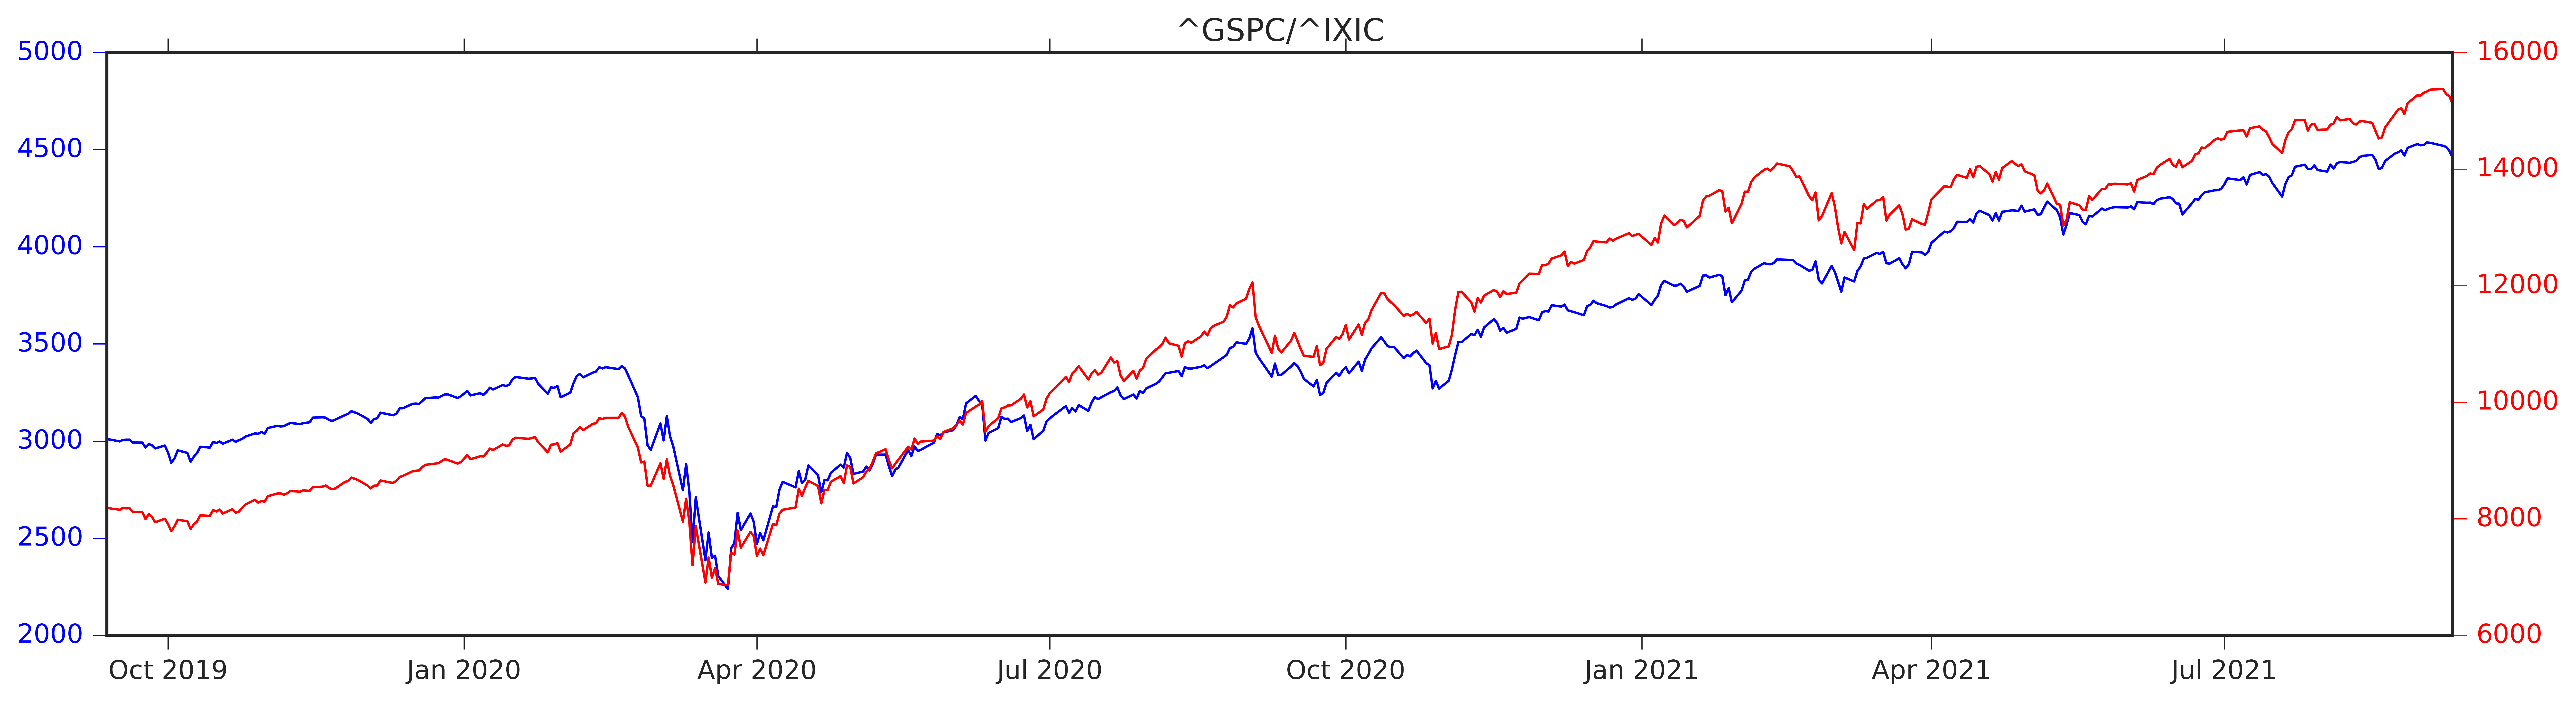

In [27]:
# used for local change only, rcParams used for global change
with plt.style.context("seaborn-ticks"):
    p_twinx()

In [28]:
# # high c/high gamma overfitting
# # low c/low gamma underfitting

# # data pre-processing
# X = df.iloc[:,0:5]
# y = df.iloc[:,-1]

# # MinMaxScaler
# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

In [29]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

# # train the model
# svm = SVC(C=1.0, kernel="linear", gamma="scale")
# svm.fit(X_train, y_train)

# # prediction
# pred = svm.predict(X_test)
# pred

# # classification report and confusion matrix

# print("Classification report:")
# print(classification_report(y_test, pred))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, pred))

# print("Accuracy score:")
# print(accuracy_score(y_test, pred).round(2))

In [30]:
# low gamma considers further away points to fit a hyperplane
# high gamma considers only close points to fit a hyperplane (prone to overfitting)
# too much emphasis on close points and not much on further away points - high gamma

# gridsearchcv
# param_grid = {"C":[0.1,1,10,100,1000], "gamma":[1,0.1,0.01,0.001], "kernel":["rbf", "poly", "sigmoid"]}
# svm_grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
# # verbose just shows how much of text output during calculation to display

# svm_grid.fit(X_train, y_train)
# svm_grid.best_params_

In [31]:
# # prediction with gridsearchcv (then classification report/confusion matrix)/accuracy score
# svm_grid_pred = svm_grid.predict(X_test)

# print("Classification report:")
# print(classification_report(y_test, svm_grid_pred))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, svm_grid_pred))

# print("Accuracy score:")
# print(accuracy_score(y_test, svm_grid_pred).round(2))